In [1]:
import xgboost as xgb
import awkward as ak
import matplotlib.pyplot as plt
import hist
import warnings
import pickle
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import numpy as np
import pickle

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [5]:
hgg_ratios = 100

In [6]:
mcd_ratios = 1291

In [7]:
with open(f'sub_ratios/{hgg_ratios}.pkl', 'rb') as f:
    hgg_feature_names = pickle.load(f)

In [8]:
with open(f'sub_ratios/{mcd_ratios}.pkl', 'rb') as f:
    mcd_feature_names = pickle.load(f)

In [9]:
columns = [f'train_ratios.{i}' for i in mcd_feature_names].append('goodjets')

In [10]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/hgg/batch2025/inputs/test/hgg.parquet', columns=columns)
qcd = ak.from_parquet('/scratch365/cmoore24/training/hgg/batch2025/inputs/test/qcd.parquet', columns=columns)

In [11]:
path = f'/scratch365/cmoore24/training/hgg/batch2025/outputs/bdt/{hgg_ratios}'

tagger_bst = xgb.Booster()
tagger_bst.load_model(f'{path}/bdt_model.json')

scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

hgg_np = np.column_stack([ak.to_numpy(hgg.train_ratios[feature]) for feature in hgg_feature_names])
qcd_np = np.column_stack([ak.to_numpy(qcd.train_ratios[feature]) for feature in hgg_feature_names])

hgg_np = scaler.transform(hgg_np)
qcd_np = scaler.transform(qcd_np)

hgg_xgb = xgb.DMatrix(hgg_np, feature_names=hgg_feature_names)
qcd_xgb = xgb.DMatrix(qcd_np, feature_names=hgg_feature_names)

hgg['hgg_scores'] = tagger_bst.predict(hgg_xgb)
qcd['qcd_scores'] = tagger_bst.predict(qcd_xgb)

In [12]:
path = f'/scratch365/cmoore24/training/hgg/ecf_vs_data/bdt/output/{mcd_ratios}'

scaling_bst = xgb.Booster()
scaling_bst.load_model(f'{path}/bdt_model.json')

scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

hgg_np = np.column_stack([ak.to_numpy(hgg.train_ratios[feature]) for feature in mcd_feature_names])
qcd_np = np.column_stack([ak.to_numpy(qcd.train_ratios[feature]) for feature in mcd_feature_names])

hgg_np = scaler.transform(hgg_np)
qcd_np = scaler.transform(qcd_np)

hgg_xgb = xgb.DMatrix(hgg_np, feature_names=mcd_feature_names)
qcd_xgb = xgb.DMatrix(qcd_np, feature_names=mcd_feature_names)

hgg['hgg_scales'] = scaling_bst.predict(hgg_xgb)
qcd['qcd_scales'] = scaling_bst.predict(qcd_xgb)

In [13]:
hgg_weight = ((1-hgg.hgg_scales)/hgg.hgg_scales)
hgg_weight = hgg_weight / np.mean(hgg_weight)

In [14]:
qcd_weight = ((1-qcd.qcd_scales)/qcd.qcd_scales)
qcd_weight = qcd_weight / np.mean(qcd_weight)

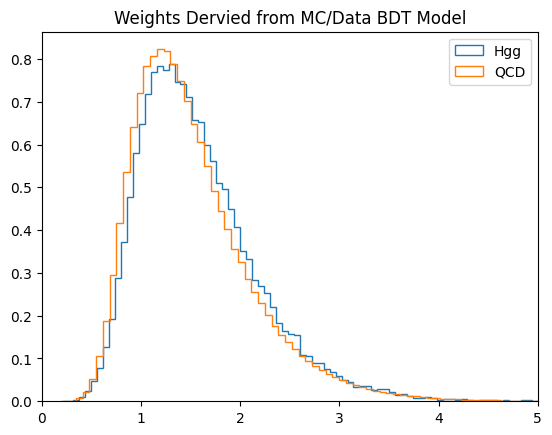

In [15]:
plt.hist((1-hgg.hgg_scales)/hgg.hgg_scales, histtype='step', bins=100, density=True, label='Hgg')
plt.hist((1-qcd.qcd_scales)/qcd.qcd_scales, histtype='step', bins=100, density=True, label='QCD')
plt.legend()
plt.title('Weights Dervied from MC/Data BDT Model')
plt.xlim(0, 5)
# plt.axvline(x=1.1)
plt.show()

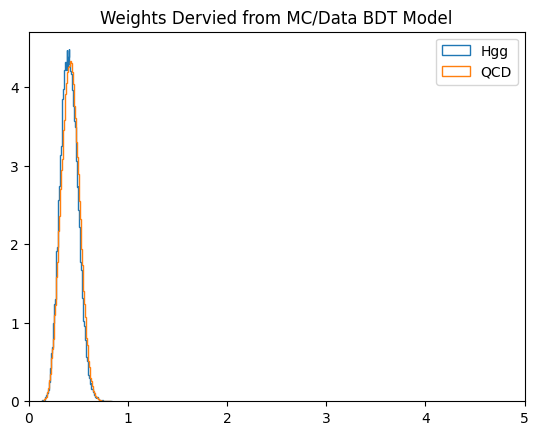

In [16]:
plt.hist(hgg.hgg_scales, histtype='step', bins=100, density=True, label='Hgg')
plt.hist(qcd.qcd_scales, histtype='step', bins=100, density=True, label='QCD')
plt.legend()
plt.title('Weights Dervied from MC/Data BDT Model')
plt.xlim(0, 5)
# plt.axvline(x=1.1)
plt.show()

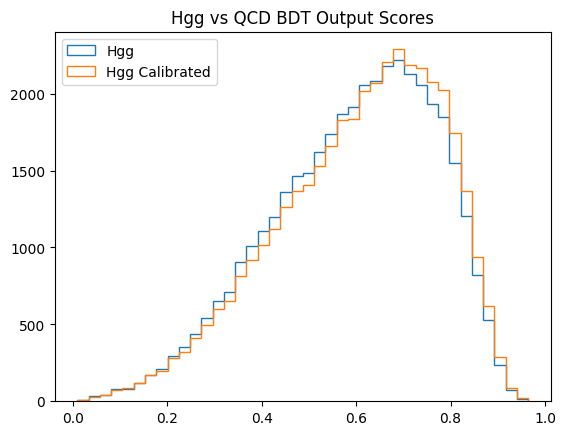

In [25]:
plt.hist(hgg.hgg_scores, bins=40, histtype='step', label='Hgg', density=False)
plt.hist(hgg.hgg_scores, bins=40, histtype='step', label='Hgg Calibrated', density=False, weights=hgg_weight)
# plt.hist(qcd.qcd_scores, bins=40, histtype='step', label='QCD', density=False)
# plt.hist(qcd.qcd_scores, bins=40, histtype='step', label='QCD Calibrated', density=False, weights=qcd_weight)
plt.title(f'Hgg vs QCD BDT Output Scores')
plt.legend()
plt.show()

In [19]:
scores_orig = ak.concatenate([hgg.hgg_scores, qcd.qcd_scores])
labels_orig = ak.concatenate([ak.ones_like(hgg.hgg_scores), ak.zeros_like(qcd.qcd_scores)])
fpr_orig, tpr_orig, _ = roc_curve(labels_orig, scores_orig)
roc_auc_orig = auc(fpr_orig, tpr_orig)

In [20]:
scores_cal = ak.concatenate([hgg.hgg_scores, qcd.qcd_scores])
labels_cal = labels_orig  # same labels
weights_cal = ak.concatenate([hgg_weight, qcd_weight])
fpr_cal, tpr_cal, _ = roc_curve(labels_cal, scores_cal, sample_weight=weights_cal)
roc_auc_cal = auc(fpr_cal, tpr_cal)

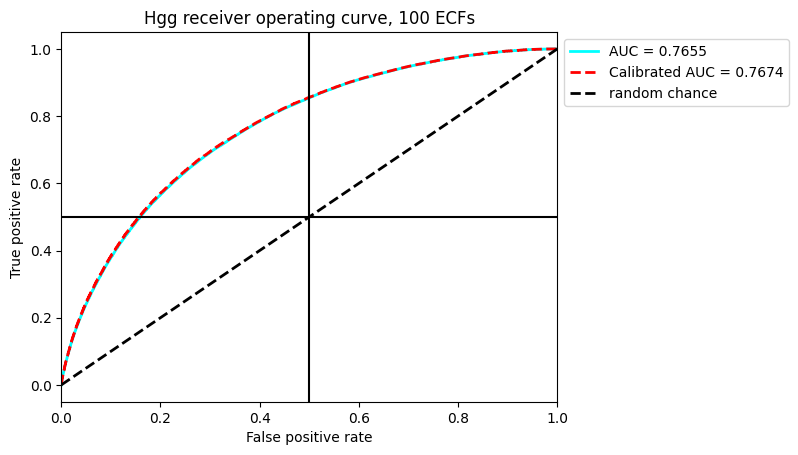

In [21]:
plt.plot(fpr_orig, tpr_orig, lw=2, color="cyan", label="AUC = %.4f" % (roc_auc_orig))
plt.plot(fpr_cal, tpr_cal, lw=2, color="red", label="Calibrated AUC = %.4f" % (roc_auc_cal), linestyle='--')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve, {ratios} ECFs")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [22]:
roc_auc_orig - roc_auc_cal

-0.0018264370410743247